<a href="https://colab.research.google.com/github/ranton256/classifying_concord/blob/main/supervised_ML_identify_author.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Machine Learning - Identify Author


In [1]:
%pip install -q spacy

In [2]:
# you will need to download the spacy model for english.
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 109.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# %pip install -r requirements.txt

In [4]:
import spacy

## The Dataset
Our two datasets are constructed from two related works of 19th century American transcendentalism. These are both public domain.

1. [Essays by Ralph Waldo Emerson by Ralph Waldo Emerson](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F16643)
2. [Walden, and On The Duty Of Civil Disobedience by Henry David Thoreau](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F205)

These two authors had different writing styles but shared more than their philosophical interests—they were neighbors in Concord, Massachusetts.

These two works are also similar in length when formatted as plain text.

We will use spaCy to segment each work into sections of roughly 3 to 5 sentences each, then build a datafrom of the text including a label of 'emerson' or 'thoreau', then shuffle and split that into train and test sets for training some machine learning models to classify them by predicting which author they are from and compare the results.

We will also preprocess text to remove stopwords,and perform lemmatization.

In [5]:
emerson_txt_url = "https://www.gutenberg.org/ebooks/16643.txt.utf-8"
thoreau_txt_url = "https://www.gutenberg.org/ebooks/205.txt.utf-8"


In [6]:
import requests
from pathlib import Path

In [7]:
def download_file(url):
  local_filename = Path(url.split('/')[-1])
  result = requests.get(url)
  result.raise_for_status()
  with open(local_filename, "wb") as f:
      f.write(result.content)
  return local_filename

In [8]:
emerson_file = download_file(emerson_txt_url)
thoreau_file = download_file(thoreau_txt_url)

In [9]:
!head -n 50 {emerson_file}

﻿The Project Gutenberg eBook of Essays by Ralph Waldo Emerson
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Essays by Ralph Waldo Emerson

Author: Ralph Waldo Emerson

Editor: Edna Henry Lee Turpin

Release date: September 4, 2005 [eBook #16643]
                Most recently updated: April 29, 2022

Language: English

Credits: Curtis A. Weyant, Sankar Viswanathan and the Online Distributed Proofreading Team


*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***




                                ESSAYS

                                  BY

                    

In [10]:
!head -n 50 {thoreau_file}

﻿The Project Gutenberg eBook of Walden, and On The Duty Of Civil Disobedience
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Walden, and On The Duty Of Civil Disobedience

Author: Henry David Thoreau

Release date: January 1, 1995 [eBook #205]
                Most recently updated: September 19, 2024

Language: English

Credits: Judith Boss, and David Widger


*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***
WALDEN




and



ON THE DUTY OF CIVIL DISOBEDIENCE



by Henry David Thoreau


cover


Contents


 WALDEN

 Economy
 Where I Lived, and 

In [11]:
# Let's strip the frontmatter lines off the start of each file.
# remove each line preceding one that contains "START OF THE PROJECT GUTENBERG EBOOK "
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {emerson_file}
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {thoreau_file}

25:*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***
23:*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***


In [12]:
def trim_frontmatter(filename):
  with open(filename) as f:
    lines = f.readlines()

  n_trim_lines = 0
  for i, line in enumerate(lines):
    if "START OF THE PROJECT GUTENBERG EBOOK" in line:
      n_trim_lines = i + 1
      break

  trimmed_lines = lines[n_trim_lines:]
  trimmed_content = '\n'.join(trimmed_lines)
  new_filename = f"trimmed_{filename}"
  with open(new_filename, "w") as f:
    f.write(trimmed_content)
  return new_filename

In [13]:
trimmed_emerson_file = trim_frontmatter(emerson_file)
trimmed_thoreau_file = trim_frontmatter(thoreau_file)

In [14]:
!head {trimmed_emerson_file}
!head {trimmed_thoreau_file}









                                ESSAYS

WALDEN











In [15]:
from collections import deque
from random import randint
import itertools


In [16]:
nlp = spacy.load("en_core_web_sm")
# if you have an error here, make sure you ran the "!python -m spacy download en_core_web_sm" command in the earlier cell.

In [17]:
def segment_doc(filename):
  with open(filename) as f:
    text = f.read()
  doc = nlp(text)
  assert doc.has_annotation("SENT_START")

  sent_dq = deque()
  #it = doc.sents.__iter__()
  n = randint(3, 5)

  for sent in doc.sents:
    sent_dq.append(sent)
    if len(sent_dq) > n:
      sent_dq.popleft()
      snippet = " ".join(sent.text for sent in sent_dq)
      yield snippet
      n = randint(3, 5)
      sent_dq.clear()

In [18]:
import pandas as pd

In [19]:
def dataframe_from_file(file_path):
  segments = segment_doc(file_path)

  df = pd.DataFrame(segments, columns=["text"])
  return df


In [20]:
emerson_df = dataframe_from_file(trimmed_emerson_file)
emerson_df.to_csv("emerson.csv")
emerson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1068 non-null   object
dtypes: object(1)
memory usage: 8.5+ KB


In [21]:
emerson_df.head()

,text
0,The editors of the several volumes will be\n\n...
1,He entered Harvard\n\nat the early age of four...
2,Although he was not strong enough to attend al...
3,In\n\nhis other pastoral duties Emerson was no...
4,"""\n\n\n\nEmerson did not long remain a ministe..."


In [22]:

thoreau_df = dataframe_from_file(trimmed_thoreau_file)
thoreau_df.to_csv("thoreau.csv")
thoreau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    830 non-null    object
dtypes: object(1)
memory usage: 6.6+ KB


In [23]:
thoreau_df.head()

,text
0,I lived there two\n\nyears and two months. At ...
1,Others have been\n\ncurious to learn what port...
2,"Moreover, I, on my side, require of every writ..."
3,What\n\nI have heard of Brahmins sitting expos...
4,"Why should they eat their sixty acres, when ma..."


In [24]:
# combine and shuffle the datasets, using a consistent random seed.
from sklearn.utils import shuffle

d1 = emerson_df.copy()
d1["label"] = "emerson"

d2 = thoreau_df.copy()
d2["label"] = "thoreau"

combined_df = pd.concat([d1, d2])
combined_df = shuffle(combined_df, random_state=7919)
combined_df.to_csv("combined.csv")
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1898 entries, 346 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1898 non-null   object
 1   label   1898 non-null   object
dtypes: object(2)
memory usage: 44.5+ KB


,text,label
346,"Wait, and thy heart shall speak. Wait until th...",emerson
462,"I have found repeatedly, of late years, that I...",thoreau
607,And perhaps at evening\n\nI see the hunters re...,thoreau
75,It is\n\npossible to invent a house still more...,thoreau
243,"If we live in the nineteenth century, why\n\ns...",thoreau


## Now we have our dataset in combined.csv


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# you can start here if csv files were already created.
from sklearn.feature_extraction.text import TfidfVectorizer

<ipython-input-27-33f8a76ce336>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=combined_df["label"], palette="rocket")


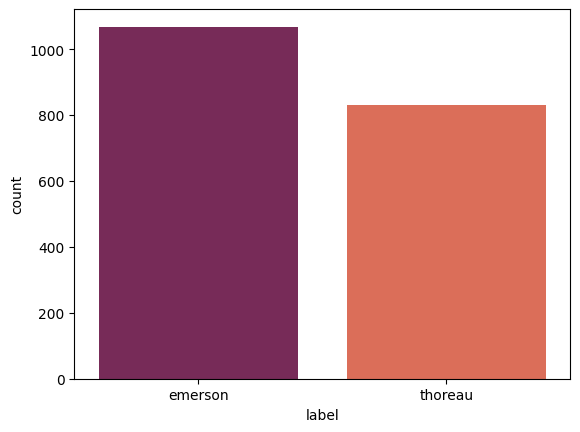

In [27]:
sns.countplot(x=combined_df["label"], palette="rocket")
plt.show()


In [28]:
%pip install -q wordcloud

In [29]:
from spacy.lang.en import STOP_WORDS
my_stopwords = STOP_WORDS

', '.join(my_stopwords)

"her, last, done, will, than, your, we, just, everyone, in, again, side, nine, whoever, also, if, then, though, whole, wherein, since, no, all, ourselves, was, why, seems, ‘ve, she, regarding, now, nevertheless, perhaps, every, you, are, might, enough, anyway, see, below, none, therein, so, had, the, too, same, am, almost, out, because, onto, take, first, formerly, ever, thereafter, any, often, were, there, between, across, either, each, ca, do, of, ‘ll, becomes, many, 'll, beforehand, beside, except, would, its, upon, several, they, have, go, seem, seemed, third, already, everything, his, such, among, only, through, whereas, him, becoming, eight, other, keep, as, above, least, and, toward, sometimes, otherwise, my, rather, both, not, although, from, bottom, n't, around, on, show, here, much, or, various, moreover, could, yourselves, neither, somewhere, ours, say, where, latterly, has, myself, make, may, amount, one, thru, he, ‘re, amongst, nor, whenever, yours, next, using, but, herse

In [30]:
# Show wordcloud from each dataset.
from wordcloud import WordCloud


def plot_word_cloud(text_sections, title):
  cloud = WordCloud(background_color='black', stopwords=my_stopwords).generate(str(text_sections))
  fig = plt.figure(figsize=(12,8), facecolor='white')
  plt.imshow(cloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(title, fontsize=48)
  plt.tight_layout(pad=0)
  plt.show()




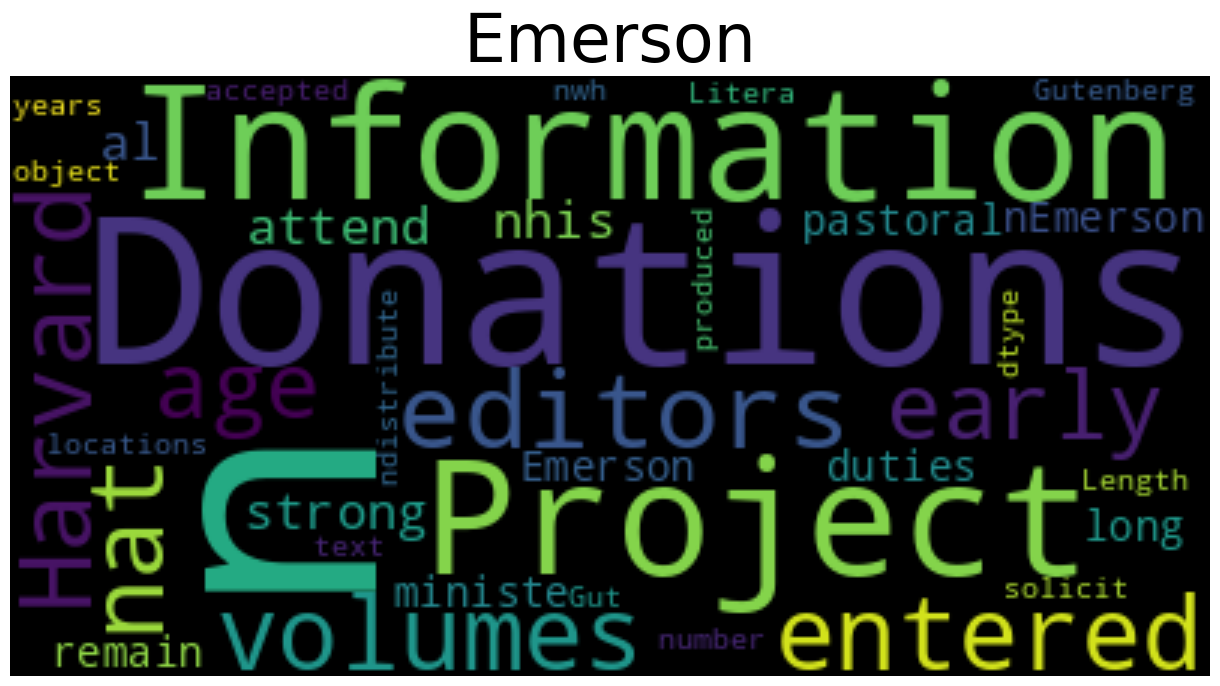

In [31]:
plot_word_cloud(emerson_df["text"], "Emerson")

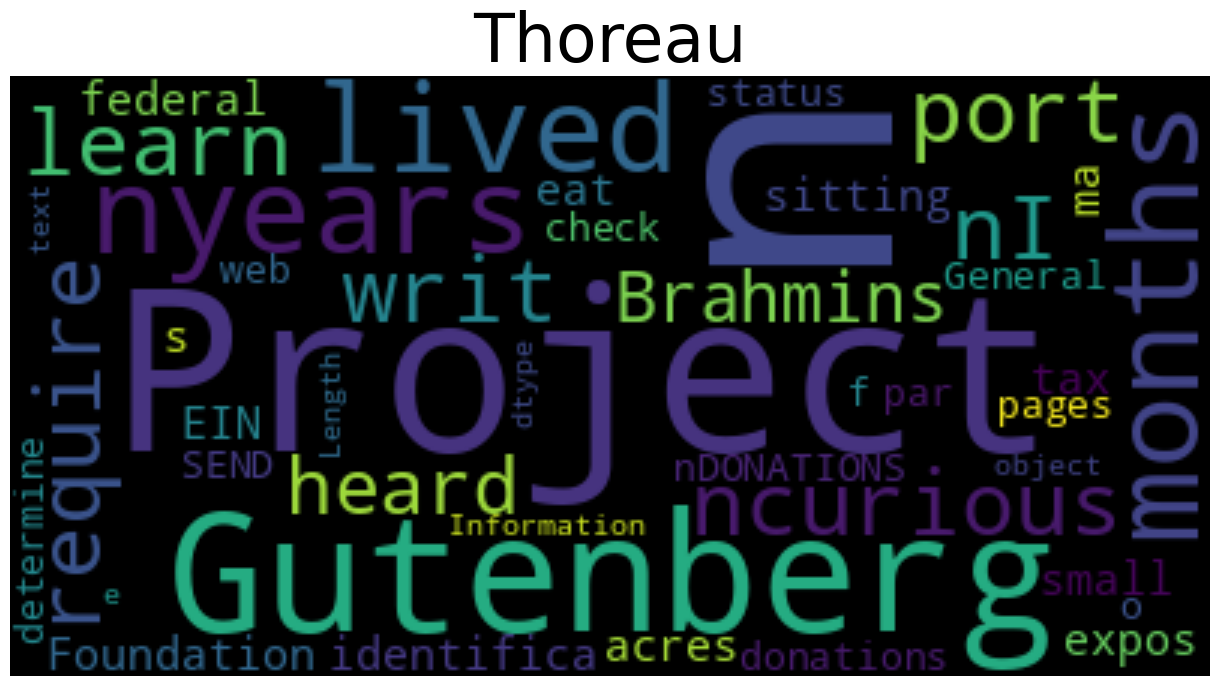

In [32]:
plot_word_cloud(thoreau_df["text"], "Thoreau")

## Traditional (Non-Transformer) Models

In [36]:
# Preprocess text to remove stopwords, and perform lemmatization.

final_text = []
for index,entry in enumerate(combined_df['text']):
  doc = nlp(entry.lower())
  Final_words = []
  for word in doc:
    if not word.is_stop and not word.is_punct:
      Final_words.append(word.lemma_)
  final_text.append(' '.join(Final_words))



In [37]:
combined_df['final_text'] = final_text
combined_df.head()

,text,label,final_text
150,Even those who seem for a long while not to ha...,thoreau,long inquire \n\n narrowly find store somebody...
363,"This is a man, a woman! Kiss thy lord,\n\nAnd ...",emerson,man woman kiss thy lord \n\n live freedom will...
614,The Raphael in the Dresden gallery[672] (the o...,emerson,raphael dresden gallery[672 great \n\n affect ...
618,They are among the\n\nmost simple and indigeno...,thoreau,\n\n simple indigenous animal product ancient ...
881,Why does Emerson use here the\n\nFrench word?]...,emerson,emerson use \n\n french word \n\n\n\n footnot...


In [41]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df["final_text"])
y = combined_df["label"]


In [42]:
# split our data into train and test sets.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4909)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (1527, 11908)
y_train: (1527,)
x_test: (382, 11908)
y_test: (382,)


In [43]:
from sklearn.linear_model import LogisticRegression


In [44]:
# -2 for n_jobs is all but one CPU available.
lr_model = LogisticRegression(solver='saga', random_state=8102, n_jobs=-2)

lr_model.fit(x_train, y_train)

LogisticRegression(n_jobs=-2, random_state=8102, solver='saga')

In [45]:
y_pred = lr_model.predict(x_test)

In [33]:
from sklearn.metrics import f1_score

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Markdown, display

def show_metrics(y_test, y_pred, model_name):
  display(Markdown(f"# {model_name}"))

  print(classification_report(y_test,y_pred))
  print("Test accuracy:", accuracy_score(y_test,y_pred))
  cm = confusion_matrix(y_test, y_pred)

  labels = ["emerson", "thoreau"]
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

# Logistic Regression

              precision    recall  f1-score   support

     emerson       0.83      0.96      0.89       207
     thoreau       0.94      0.77      0.85       175

    accuracy                           0.87       382
   macro avg       0.89      0.87      0.87       382
weighted avg       0.88      0.87      0.87       382

Test accuracy: 0.8743455497382199


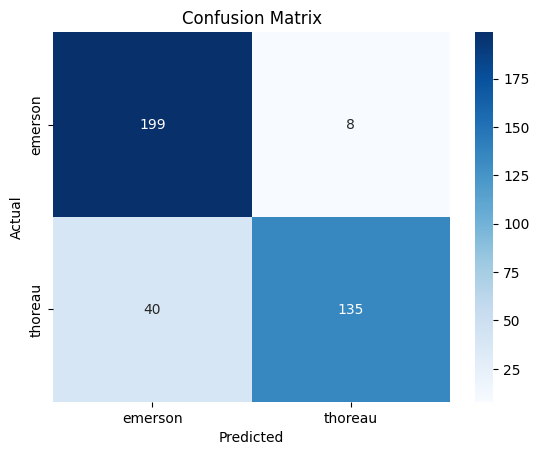

In [48]:
show_metrics(y_test, y_pred, "Logistic Regression")

In [49]:
# Let's compare that to random forests.


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)


RandomForestClassifier()

In [50]:
y_pred_rf = rf.predict(x_test)

# Random Forest

              precision    recall  f1-score   support

     emerson       0.80      0.95      0.87       207
     thoreau       0.92      0.72      0.81       175

    accuracy                           0.84       382
   macro avg       0.86      0.83      0.84       382
weighted avg       0.85      0.84      0.84       382

Test accuracy: 0.8429319371727748


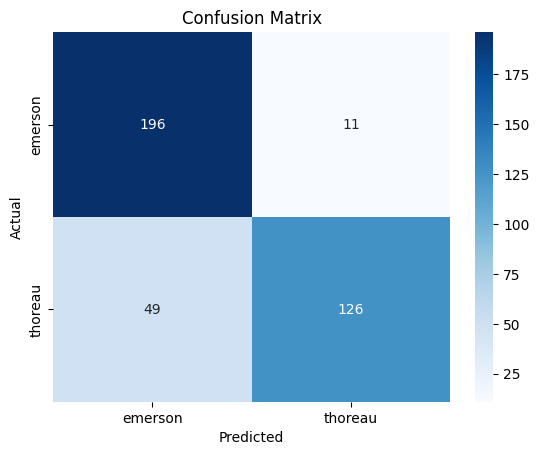

In [51]:
show_metrics(y_test, y_pred_rf, "Random Forest")

In [52]:
from sklearn import svm

In [53]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train,y_train)
clf

SVC()

In [54]:
y_pred_svm = clf.predict(x_test)

# SVM

              precision    recall  f1-score   support

     emerson       0.85      0.96      0.90       207
     thoreau       0.94      0.80      0.86       175

    accuracy                           0.88       382
   macro avg       0.89      0.88      0.88       382
weighted avg       0.89      0.88      0.88       382

Test accuracy: 0.8848167539267016


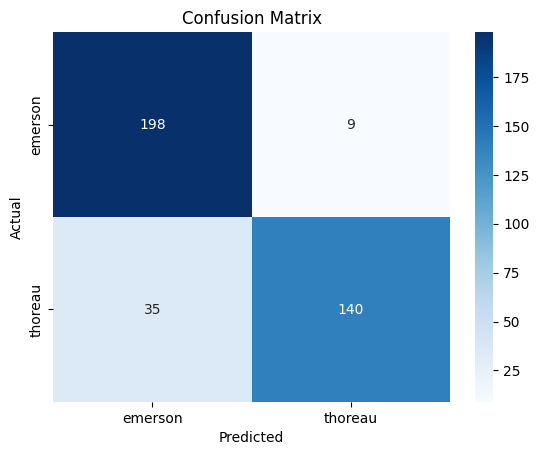

In [55]:
show_metrics(y_test, y_pred_svm, "SVM")

In [38]:
# TODO: if not colab
#%pip install -q transformers

In [39]:
# TODO: if not colab
#%pip install -q torch

In [40]:
import torch

In [41]:
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [60]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_token_type_ids = False, padding="max_length", truncation=True)

model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [61]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(combined_df["text"], combined_df["label"], test_size=0.2, random_state=4909)
print(f"x_train_s: {x_train_s.shape}")
print(f"y_train_s: {y_train_s.shape}")
print(f"x_test_s: {x_test_s.shape}")
print(f"y_test_s: {y_test_s.shape}")


x_train_s: (1527,)
y_train_s: (1527,)
x_test_s: (382,)
y_test_s: (382,)


In [62]:
x_train_tok = tokenizer(x_train_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_train_tok = y_train_s.tolist()

x_test_tok = tokenizer(x_test_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_test_tok = y_test_s.tolist()


In [63]:
x_train_tok[0:2]

[Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [64]:

print(x_train_tok.keys())


#move onto device (GPU)
x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}

dict_keys(['input_ids', 'attention_mask'])


<ipython-input-64-cbedc1b8b59f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
<ipython-input-64-cbedc1b8b59f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}


In [65]:
with torch.no_grad():
  hidden_train = model(**x_train_tok)
  hidden_test = model(**x_test_tok)

# Get the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_test = hidden_test.last_hidden_state[:,0,:]

In [66]:
x_train_db = cls_train.to("cpu")
# y_train_tok

x_test_db = cls_test.to("cpu")
# y_test_tok


In [67]:
lr_model2 = LogisticRegression(C=1, solver='saga', random_state=8102, n_jobs=-2, max_iter=10_000)

lr_model2.fit(x_train_db,y_train_tok)

# This does not converge, with the settings used for TF-DF
# ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
# So we adjusting max_iter and experimented with C (regulation strength).

y_pred = lr_model2.predict(x_test_db)


# Logistic Regression on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.93      0.92      0.92       207
     thoreau       0.91      0.91      0.91       175

    accuracy                           0.92       382
   macro avg       0.92      0.92      0.92       382
weighted avg       0.92      0.92      0.92       382

Test accuracy: 0.918848167539267


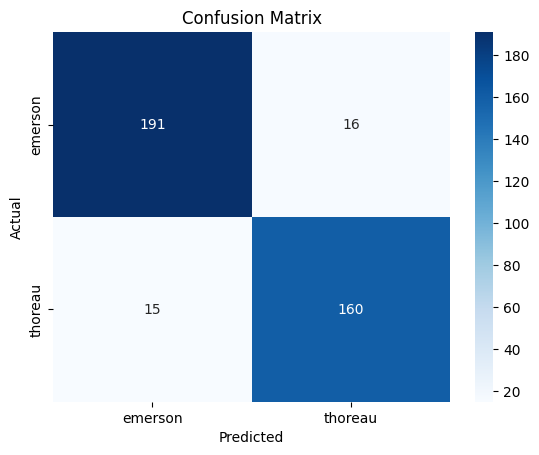

In [68]:
show_metrics(y_test_tok, y_pred, "Logistic Regression on DistilBERT hidden states")

In [69]:
rf = RandomForestClassifier()
rf.fit(x_train_db,y_train_tok)

rf.score(x_test_db,y_test_tok)

y_pred_rf = rf.predict(x_test_db)

# Random Forest on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.87      0.93      0.90       207
     thoreau       0.91      0.84      0.87       175

    accuracy                           0.89       382
   macro avg       0.89      0.88      0.89       382
weighted avg       0.89      0.89      0.89       382

Test accuracy: 0.887434554973822


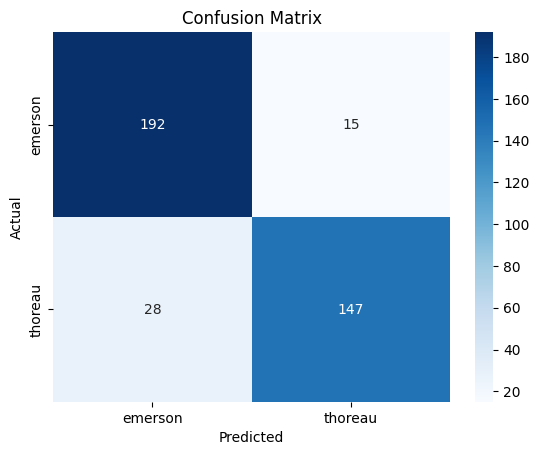

In [70]:
show_metrics(y_test_tok, y_pred_rf, "Random Forest on DistilBERT hidden states")

In [71]:
from sklearn import svm

In [72]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train_db,y_train_tok)

y_pred_svm = clf.predict(x_test_db)

# SVM on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.88      0.95      0.92       207
     thoreau       0.94      0.85      0.89       175

    accuracy                           0.91       382
   macro avg       0.91      0.90      0.90       382
weighted avg       0.91      0.91      0.91       382

Test accuracy: 0.9057591623036649


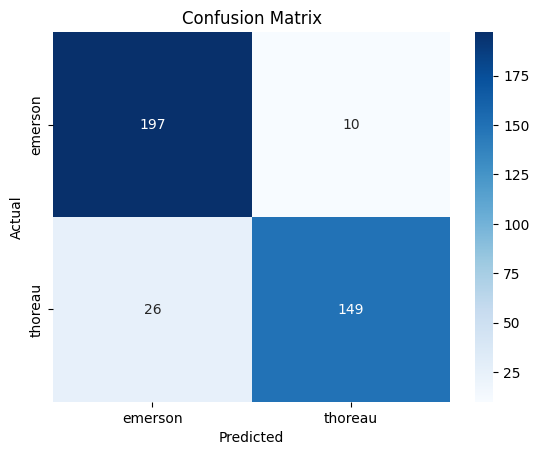

In [73]:
show_metrics(y_test_tok, y_pred_svm, "SVM on DistilBERT hidden states")

In [74]:

from transformers import DistilBertForSequenceClassification

# Define the model with random weights, suitable for binary classification (2 classes)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
# we already have the appropriate tokenizer from before.



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
# create our optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [76]:
!pip install -q datasets

In [77]:
from sklearn import preprocessing

# Create a copy of our dataframe
trans_df = combined_df.copy()

# drop the preprocessed text column which we aren't using.
trans_df.drop("final_text", axis=1, inplace=True)

# transform our labels into numeric values.
le = preprocessing.LabelEncoder()
my_labels = trans_df["label"].tolist()
le.fit(my_labels)

my_cat_labels = le.classes_
trans_df["label"] = le.transform(trans_df["label"])

print(f"{my_cat_labels=}")

trans_df.info()
trans_df.describe()
trans_df.head()


my_cat_labels=array(['emerson', 'thoreau'], dtype='<U7')
<class 'pandas.core.frame.DataFrame'>
Index: 1909 entries, 469 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1909 non-null   object
 1   label   1909 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.7+ KB


,text,label
469,"To remove\n\nyour residence a couple of miles,...",0
624,"Like the marmots in the surrounding\n\nhills, ...",1
626,Goethe's Tasso[676] is very likely to be a pre...,0
96,"He was there to represent\n\nspectatordom, and...",1
320,Some priest who\n\ncould pronounce the Greek i...,1


In [78]:
from datasets import Dataset
from transformers import AutoTokenizer

# for simplicity, we are just splitting the dataset again.
train_df, test_df = train_test_split(trans_df, test_size=0.2, random_state=4909)



train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

In [79]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    # this parameter was apparently removed recently.
    # evaluation_strategy="epoch",
    logging_strategy="epoch"
)

# Define Trainer object for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-79-7e148adf619d>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ranton (ranton-fieldjay-com) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
191,0.369200
382,0.209700
573,0.141300
764,0.119300
955,0.085600


TrainOutput(global_step=955, training_loss=0.18502708155447276, metrics={'train_runtime': 69.1206, 'train_samples_per_second': 110.459, 'train_steps_per_second': 13.816, 'total_flos': 445438445131020.0, 'train_loss': 0.18502708155447276, 'epoch': 5.0})

In [80]:
# Save the model.
trainer.save_model('model')

In [81]:
# This is how you can load the model.

# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained("./model")

In [82]:
def predictor(text):
  #inputs = tokenizer(text, return_tensors="pt")
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}

  with torch.no_grad():
      logits = model(**inputs).logits
  predictions = torch.argmax(logits, dim=-1)
  return predictions


In [83]:
x_test_trans = test_dataset["text"]
y_test_trans = test_dataset["label"]

# sanity test a few inference inputs.
for txt, lbl in zip(x_test_trans[:5], y_test_trans[:5]):
  pred = predictor( txt)
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")

<ipython-input-82-118abc29aba2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


thoreau: pred=thoreau, txt='How now, Hermit, is it too soon? I have got just thirteen whole\n\nones, beside several which are imperfect or undersized; but they will\n\ndo for the smaller fry; they do not cover up the hook so much. Those\n\nvillage worms are quite too large; a shiner may make a meal off one\n\nwithout finding the skewer.\n\n\n\n _'
thoreau: pred=emerson, txt='Do\n\nnot trouble yourself much to get new things, whether clothes or\n\nfriends. Turn the old; return to them. Things do not change; we change.\n\n Sell your clothes and keep your thoughts. God will see that you do not\n\nwant society.'
emerson: pred=emerson, txt='Juvenal (Satire XI. 27) says that this precept\n\ndescended from heaven. "Know thyself" and "Nothing too much" were\n\ninscribed upon the Delphic oracle.\n\n\n\n    "Know then thyself, presume not God to scan;\n\n    The proper study of mankind is man. "\n\n\n\n]\n\n\n\n[Footnote 15: Observe the brisk movement of these sentences.'
thoreau: pred=emerson, 

In [84]:
y_pred_trans = [predictor(txt) for txt in x_test_trans]

for txt, lbl, pred in zip(x_test_trans[:5], y_test_trans[:5], y_pred_trans[:5]):
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")


<ipython-input-82-118abc29aba2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


thoreau: pred=thoreau, txt='How now, Hermit, is it too soon? I have got just thirteen whole\n\nones, beside several which are imperfect or undersized; but they will\n\ndo for the smaller fry; they do not cover up the hook so much. Those\n\nvillage worms are quite too large; a shiner may make a meal off one\n\nwithout finding the skewer.\n\n\n\n _'
thoreau: pred=thoreau, txt='Do\n\nnot trouble yourself much to get new things, whether clothes or\n\nfriends. Turn the old; return to them. Things do not change; we change.\n\n Sell your clothes and keep your thoughts. God will see that you do not\n\nwant society.'
emerson: pred=emerson, txt='Juvenal (Satire XI. 27) says that this precept\n\ndescended from heaven. "Know thyself" and "Nothing too much" were\n\ninscribed upon the Delphic oracle.\n\n\n\n    "Know then thyself, presume not God to scan;\n\n    The proper study of mankind is man. "\n\n\n\n]\n\n\n\n[Footnote 15: Observe the brisk movement of these sentences.'
thoreau: pred=emerson, 

In [85]:
y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]

<ipython-input-85-29869180259a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]


In [86]:
y_test_trans = [torch.tensor(v).cpu() for v in y_test_trans]

# Fine-tuned DistilBERT

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       220
           1       0.89      0.96      0.92       162

    accuracy                           0.93       382
   macro avg       0.93      0.93      0.93       382
weighted avg       0.93      0.93      0.93       382

Test accuracy: 0.9293193717277487


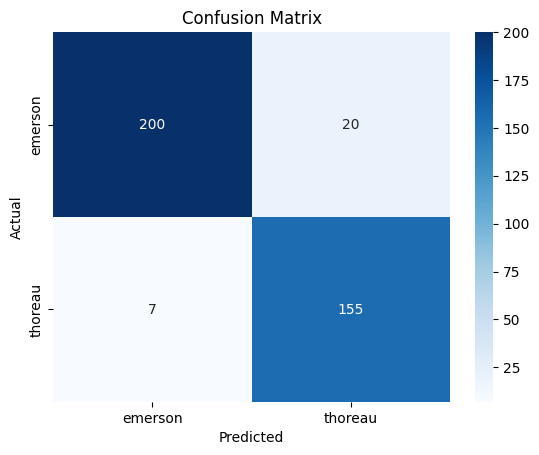

In [87]:
show_metrics(y_pred_trans, y_test_trans, "Fine-tuned DistilBERT")

## Let's check out the test samples that are misclassified.

In [88]:
def scalar_from_tensor(t):
  if t.dim() == 0:
    return t.item()
  elif t.dim() == 1:
    return t[0].item()
  else:
    raise ValueError(f"Unexpected tensor dimension: {t.dim()}")


In [89]:

y_test_trans = [scalar_from_tensor(t) for t in y_test_trans]
y_pred_trans = [scalar_from_tensor(t) for t in y_pred_trans]

print(f"y_test_trans: {y_test_trans[:5]}")
print(f"y_pred_trans: {y_pred_trans[:5]}")


y_test_trans: [1, 1, 0, 1, 1]
y_pred_trans: [1, 1, 0, 0, 1]


In [90]:
print("my_cat_labels")

rows = []
for i, (txt, lbl, pred) in enumerate(zip(x_test_trans, y_test_trans, y_pred_trans)):
  if lbl != pred:
    print(f"{lbl=},{pred=}")
    row =(my_cat_labels[lbl], my_cat_labels[pred], txt)
    print(f"{row=}")
    rows.append(row)

n_miss = len(rows)
print(f"Count of misclassified = {n_miss}")
misclassified_df = pd.DataFrame(rows, columns=["actual", "predicted", "text"])
misclassified_df.head(n_miss)


my_cat_labels
lbl=1,pred=0
row=(np.str_('thoreau'), np.str_('emerson'), 'As if one were to begin\n\nthe day with long-suffering, and hire a man to hoe his potatoes; and in\n\nthe afternoon go forth to practise Christian meekness and charity with\n\ngoodness aforethought! Consider the China pride and stagnant\n\nself-complacency of mankind. This generation inclines a little to\n\ncongratulate itself on being the last of an illustrious line; and in\n\nBoston and London and Paris and Rome, thinking of its long descent, it\n\nspeaks of its progress in art and science and literature with\n\nsatisfaction. There are the Records of the Philosophical Societies, and\n\nthe public Eulogies of _Great Men!_')
lbl=1,pred=0
row=(np.str_('thoreau'), np.str_('emerson'), 'The material was pure, and his\n\nart was pure; how could the result be other than wonderful?\n\n\n\n No face which we can give to a matter will stead us so well at last as\n\nthe truth. This alone wears well. For the most part, we are

,actual,predicted,text
0,thoreau,emerson,As if one were to begin\n\nthe day with long-s...
1,thoreau,emerson,"The material was pure, and his\n\nart was pure..."
2,thoreau,emerson,But it is the fault of the\n\ngovernment itsel...
3,thoreau,emerson,You may charge a reasonable fee for copies of ...
4,emerson,thoreau,I am overinstructed for my return. Henceforth ...
5,thoreau,emerson,What is\n\ncalled eloquence in the forum is co...
6,emerson,thoreau,I do not wish to please him; I wish that he\n\...
7,thoreau,emerson,Section 5. General Information About Project G...
8,thoreau,emerson,To learn more about the Project Gutenberg Lite...
9,thoreau,emerson,You find thus in the\n\nvery sands an anticipa...


## Postscript - Few short learning with a modern LLM

Another technique that is used recently is to use a few-shot learning to inject examples as context into an existing LLM model.


In [46]:
# choose some examples of each author from our training set.
import re

training_df = combined_df.copy()

print(training_df.head())

few_shot_num_examples = 10

thoreau_samples = training_df[ training_df["label"] == "thoreau"].sample(few_shot_num_examples, random_state=7809)
emerson_samples = training_df[ training_df["label"] == "emerson"].sample(few_shot_num_examples, random_state=997)

both_samples = pd.concat([thoreau_samples, emerson_samples])

# remove the training samples.
training_df.drop(both_samples.index, axis=0, inplace=True)

emerson_samples_array = emerson_samples['text'].to_list()
thoreau_samples_array = thoreau_samples['text'].to_list()

emerson_samples_array = [s.strip() for s in emerson_samples_array]
thoreau_samples_array = [s.strip() for s in thoreau_samples_array]

# replace multiple newlines with a single newline
emerson_samples_array = [re.sub(r'\n+', '\n', sample) for sample in emerson_samples_array]
thoreau_samples_array = [re.sub(r'\n+', '\n', sample) for sample in thoreau_samples_array]

print("======Emerson samples:======\n")
for idx, sample in enumerate(emerson_samples_array):
    print(f"{idx+1}: {sample}\n")

print("======Thoreau samples:======\n")
for idx, sample in enumerate(thoreau_samples_array):
    print(f"{idx+1}: {sample}\n")


                                                  text    label
346  Wait, and thy heart shall speak. Wait until th...  emerson
462  I have found repeatedly, of late years, that I...  thoreau
607  And perhaps at evening\n\nI see the hunters re...  thoreau
75   It is\n\npossible to invent a house still more...  thoreau
243  If we live in the nineteenth century, why\n\ns...  thoreau
======Emerson samples:======

1: The present object shall give you this sense of
stillness that follows a pageant which has just gone by. What splendid
distance, what recesses of ineffable pomp and loveliness in the
sunset! But who can go where they are, or lay his hand or plant his
foot thereon?

2: [Footnote 47: I. Corinthians xv. 53.]
[Footnote 48: Empyrean. The region of pure light and fire; the ninth
heaven of ancient astronomy.
    "The deep-domed empyrean
    Rings to the roar of an angel onset. "
]
[Footnote 49: Ferules.

3: The nautical almanac is a
publication containing astronomical data for the us

In [52]:
# We also need our prompt template
prompt_template = """
You are an expert literary analyst. Your task is to classify whether a given text was written by {author1} or {author2}.

Here are some example texts from each author:

{author1} examples:
{author1_examples}

{author2} examples:
{author2_examples}

Based on these examples and your knowledge of their writing styles, analyze the following text and determine whether it was written by {author1} or {author2}:

Text to classify:
{text_to_classify}

Provide your classification as either {author1} or {author2}.
"""


In [53]:
def generate_prompt(text, author1, author2):
    prompt_text = prompt_template.format(author1=author1, author2=author2, author1_examples=emerson_samples_array, author2_examples=thoreau_samples_array, text_to_classify=text)
    return prompt_text


In [48]:
example_text = """
The squirrel tribe tried the

same and succeeded. The human race is interested in these experiments,

though a few old women who are incapacitated for them, or who own their

thirds in mills, may be alarmed.

 My furniture, part of which I made myself, and the rest cost me nothing

of which I have not rendered an account, consisted of a bed, a table, a

desk, three chairs, a looking-glass three inches in diameter, a pair of

tongs and andirons, a kettle, a skillet, and a frying-pan, a dipper, a

wash-bowl, two knives and forks, three plates, one cup, one spoon, a

jug for oil, a jug for molasses, and a japanned lamp. None is so poor

that he need sit on a pumpkin. That is shiftlessness.
"""
generate_prompt(example_text, "Emerson", "Thoreau")


'\nYou are an expert literary analyst. Your task is to classify whether a given text was written by Emerson or Thoreau.\n\nHere are some example texts from each author:\n\nEmerson examples:\n[\'The great will not condescend to take anything\\nseriously; all must be as gay as the song of a canary, though it were\\nthe building of cities, or the eradication of old and foolish\\nchurches and nations, which have cumbered the earth long thousands of\\nyears. Simple hearts put all the history and customs of this world\\nbehind them, and play their own play in innocent defiance of the\\nBlue-Laws[347] of the world; and such would appear, could we see the\\nhuman race assembled in vision, like little children frolicking\\ntogether; though, to the eyes of mankind at large, they wear a stately\\nand solemn garb of works and influences.\\n 12.\', \'"Mobile mutatur semper cum principe vulgus. "\\n                    CLAUDIANUS, _De IV. Consul. Honorii_, 302.\\n]\\n [Footnote 181: _The other terror

## Done with prompt generation here.

In [118]:
# try to force some memory to free up
del model
del tokenizer

In [119]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch

# Now that we have our samples, we can inject them into an LLM.
# we will use Hugging Face's transformers library to inject the samples into the model.

# this model is small but accepts longer input sequences than BERT/DistilBERT.
#model_name = "microsoft/Phi-3-mini-4k-instruct"
# model_name = "roberta-large"
#model_name = "answerdotai/ModernBERT-base"
model_name = "Qwen/Qwen2.5-7B-Instruct"



dev_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "emerson", 1: "thoreau"},
    label2id={"emerson": 0, "thoreau": 1}
    ).to(device)

# get the tokenizer for the model.
tokenizer = AutoTokenizer.from_pretrained(model_name)



config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-7B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [50]:
# Use the model to predict the samples.
import torch

def classify_text(text, author1, author2):
    prompt_text = generate_prompt(text, author1, author2)
    inputs = tokenizer(prompt_text, return_tensors="pt") # should use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)
    inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()} # TODO: fix this, not how you copy a tensor.
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()

    output_logits = outputs.logits
    predicted_class_id = torch.argmax(output_logits, dim=1).item()
    predicted_class_label = model.config.id2label[predicted_class_id]
    predicted_probability = torch.softmax(output_logits, dim=1).max().item()

    return predicted_class_label, predicted_probability

In [54]:
# let's try a few examples.

samples = training_df.sample(3, random_state=4909)

for cnt, (idx, sample) in enumerate(samples.iterrows()):
    print(f"Example {cnt+1}:")
    print(f"Text: {sample['text']}")
    predicted_label, predicted_probability = classify_text(sample['text'], "Emerson", "Thoreau")
    print(f"Prediction: {predicted_label} ({predicted_probability:.2f})")
    print(f"Actual: {sample['label']}")
    print("-" * 80)
    print("\n")

Example 1:
Text: My gay butterfly is entangled in a spider’s web then.

 Even those who seem for a long while not to have any, if you inquire

more narrowly you will find have some stored in somebody’s barn. I look

upon England to-day as an old gentleman who is travelling with a great

deal of baggage, trumpery which has accumulated from long housekeeping,

which he has not the courage to burn; great trunk, little trunk,

bandbox and bundle. Throw away the first three at least.


<ipython-input-50-de7efffae79d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()} # TODO: fix this, not how you copy a tensor.


RuntimeError: a Tensor with 152064 elements cannot be converted to Scalar

In [122]:
%pip install -q tqdm
from tqdm import tqdm


In [123]:
#A run over the whole dataset

# since we haven't trained the model, we don't really need to split the dataset.

MAX_SAMPLES = 100  # 100 samples is enough to get a good idea of the performance.

texts = training_df["text"].tolist()
y_actual_phi = training_df["label"].tolist()


# use tqdm to show progress
y_pred_phi = [classify_text(text, "Emerson", "Thoreau")[0] for text in tqdm(texts[:MAX_SAMPLES])]

y_actual_subset = y_actual_phi[:MAX_SAMPLES]
y_pred_subset = y_pred_phi



  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-120-4388d3d376d9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}

100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


# Few shot learning

              precision    recall  f1-score   support

     emerson       0.55      1.00      0.71        55
     thoreau       0.00      0.00      0.00        45

    accuracy                           0.55       100
   macro avg       0.28      0.50      0.35       100
weighted avg       0.30      0.55      0.39       100

Test accuracy: 0.55


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


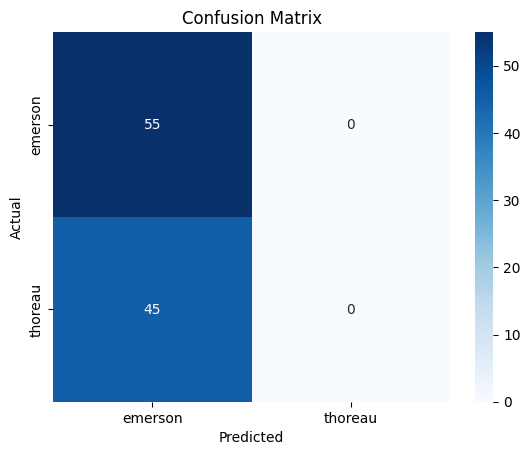

In [124]:
show_metrics(y_actual_subset, y_pred_subset, "Few shot learning")

In [138]:
# okay with langchain then

%pip install -q langchain

In [139]:
%pip install -q langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 6.9 MB/s eta 0:00:00


In [127]:
%pip install -q langchain_huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.7 MB/s eta 0:00:00


In [35]:
from langchain.prompts import PromptTemplate

In [42]:
from langchain_huggingface import HuggingFacePipeline

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

#model_id="microsoft/Phi-3-mini-4k-instruct"
model_id = "Qwen/Qwen2.5-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
pipe = pipeline(
    "text-generation", model=model, tokenizer=tokenizer, max_new_tokens=100, device=device,
    do_sample=False, # Set to False for more deterministic output
    return_full_text=False, # This is crucial to prevent the pipeline from returning the input prompt
)
llm = HuggingFacePipeline(pipeline=pipe)



Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [59]:
from langchain.output_parsers.json import SimpleJsonOutputParser


# We also need our prompt template
prompt_template = """
    "You are an expert literary analyst. Your task is to classify whether a given text was written by {author1} or {author2}.

    Return a JSON object with an `answer` key with a value of either {author1} or {author2}.

    Examples:
    Here are some example texts from each author:

    {author1} examples:
    {author1_examples}

    {author2} examples:
    {author2_examples}

    Based on these examples and your knowledge of their writing styles, analyze the following text and determine whether it was written by {author1} or {author2}:

    Text to classify:
    {text_to_classify}

    Format your response as a JSON object like this: {{"answer": "predicted_author"}}

    """

parser = SimpleJsonOutputParser()

lc_prompt_template = PromptTemplate(
    input_variables=["author1", "author2", "author1_examples", "author2_examples", "text_to_classify"],
    template=prompt_template,
    partial_variables={"format_instructions": parser.get_format_instructions()},
)


In [62]:
import re

for cnt, (idx, sample) in enumerate(samples.iterrows()):
    print(f"Example {cnt+1}:")
    print(f"Actual: {sample['label']}")

    arg_dict = {
            "author1": "emerson",
            "author2": "thoreau",
            "author1_examples": "\n".join(emerson_samples_array),
            "author2_examples": "\n".join(thoreau_samples_array),
            "text_to_classify": sample['text']
        }

    json_parser = SimpleJsonOutputParser()

    #json_chain = lc_prompt_template | llm | json_parser
    basic_chain = lc_prompt_template | llm

    response_text = basic_chain.invoke(arg_dict)
    print(f"RESPONSE: {response_text}\n")
    try:
        #output = json_chain.invoke(arg_dict)
        # find the JSON in the response using regexp
        json_pattern = r'\{.*\}'
        json_str = re.search(json_pattern, response_text).group(0)
        #output = json.loads(json_str)

        output = json_parser.parse(json_str)

        print(f"OUTPUT:\n\t{output}\n")
        # Check if the output is a dictionary and contains the expected key
        if isinstance(output, dict) and "answer" in output:
            predicted_label = output["answer"]
            print(f"Prediction: {predicted_label}")
        else:
             print(f"Prediction: Could not parse output: {output}")
    except Exception as e:
        print(f"An error occurred during processing: {e}")


    print("-" * 80)
    print("\n")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Example 1:
Actual: thoreau


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


RESPONSE:  Do not include any explanations, just the JSON object."
    {"answer": "emerson"}

OUTPUT:
	{'answer': 'emerson'}

Prediction: emerson
--------------------------------------------------------------------------------


Example 2:
Actual: thoreau


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


RESPONSE:  "
    ```json
    {"answer": "emerson"}
    ```
    ```json
    {
      "answer": "emerson"
    }
    ```
    The text contains several elements that are characteristic of Ralph Waldo Emerson's writing style, including:

    - Use of grand and poetic imagery ("a mote in the eye, or in heaven's eye," "seamsless cope remained")
    - References to nature and the sublime ("the heavens were rent, torn at last to very

OUTPUT:
	{'answer': 'emerson'}

Prediction: emerson
--------------------------------------------------------------------------------


Example 3:
Actual: emerson
RESPONSE:  Do not include any explanations, just the JSON object."
    {"answer": "emerson"}

OUTPUT:
	{'answer': 'emerson'}

Prediction: emerson
--------------------------------------------------------------------------------




In [165]:
output

'\n    "You are an expert literary analyst. Your task is to classify whether a given text was written by emerson or thoreau.\n\n    Return a JSON object with an `answer` key with a value of either emerson or thoreau.\n\n    Examples:\n    Here are some example texts from each author:\n\n    emerson examples:\n    The great will not condescend to take anything\nseriously; all must be as gay as the song of a canary, though it were\nthe building of cities, or the eradication of old and foolish\nchurches and nations, which have cumbered the earth long thousands of\nyears. Simple hearts put all the history and customs of this world\nbehind them, and play their own play in innocent defiance of the\nBlue-Laws[347] of the world; and such would appear, could we see the\nhuman race assembled in vision, like little children frolicking\ntogether; though, to the eyes of mankind at large, they wear a stately\nand solemn garb of works and influences.\n 12.\n"Mobile mutatur semper cum principe vulgus.

## Few shot take 3


In [133]:
# Take three

from torch.nn import functional as F

In [51]:
from transformers import AutoTokenizer, AutoModel

In [52]:
from transformers import BartForSequenceClassification, BartTokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-mnli')
model = BartForSequenceClassification.from_pretrained('facebook/bart-large-mnli')


In [70]:
def zero_shot_classify(premise, hypothesis, model, tokenizer):
    """Return probability of hypothesis being true."""
    input_ids = tokenizer.encode(premise, hypothesis, return_tensors='pt', truncation=True)
    logits = model(input_ids)[0]
    entail_contradiction_logits = logits[:,[0,2]]
    probs = entail_contradiction_logits.softmax(dim=1)
    true_prob = probs[:,1].item()
    return true_prob


In [71]:
# Zero shot, without the examples and system prompt.
true_prob = zero_shot_classify(
    example_text,
    'This text was authored by Ralph Waldo Emerson, and not by Henry David Thoreau',
    model, tokenizer)
print(f'Probability that the label is true: {(true_prob*100):0.2f}%')

Probability that the label is true: 7.08%


In [72]:
few_shot_hypothesis = 'This text was authored by Ralph Waldo Emerson, and not by Henry David Thoreau'

In [73]:
#
# prompt_text = generate_prompt(example_text, "Emerson", "Thoreau")
# true_prob = zero_shot_classify(
#     prompt_text,
#     few_shot_hypothesis,
#     model, tokenizer)
# print(f'Probability that the label is true: {true_prob:0.2f}%')

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Probability that the label is true: 0.01%


In [74]:
# Few shot, using our prompt and the examples.
def few_shot_classify_text(text, true_class_label, false_class_label, hypothesis):
    prompt_text = generate_prompt(text, true_class_label, false_class_label)

    predicted_probability = zero_shot_classify(
      prompt_text,
      hypothesis,
      model, tokenizer)
    label = true_class_label if predicted_probability > 0.5 else false_class_label
    return label, predicted_probability


In [76]:
pred_label, pred_prob = few_shot_classify_text(example_text, "Emerson", "Thoreau", few_shot_hypothesis)
print(f"Prediction: {pred_label} ({(pred_prob*100):.2f}%)")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Prediction: Thoreau (1.27%)


In [115]:
from tqdm import tqdm

#hypothesis = 'This text was authored by Ralph Waldo Emerson, and this text was not written by Henry David Thoreau.'
# hypothesis = "This text was written by Thoreau"
hypothesis = 'This text was written by Emerson.'
def zc_classify_text(text):
  prob = zero_shot_classify(
      text,
      hypothesis,
      model, tokenizer)
  label = "emerson" if prob > 0.5 else "thoreau"
  return label, prob


MAX_SAMPLES = 100 # TODO: remove and/or increase

texts = training_df["text"].tolist()
y_actual = training_df["label"].tolist()

x_subset = texts[:MAX_SAMPLES]
y_actual_subset = y_actual[:MAX_SAMPLES]

results = [zc_classify_text(text) for text in tqdm(x_subset)]

# use tqdm to show progress
y_pred_subset = [r[0] for r in results]




100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


In [116]:
for actual, (pred, prob) in zip(y_actual_subset, results):
  print(f"{actual=},{pred=}, {prob=}")

actual='thoreau',pred='thoreau', prob=0.12859751284122467
actual='emerson',pred='emerson', prob=0.6099186539649963
actual='emerson',pred='thoreau', prob=0.26308122277259827
actual='thoreau',pred='thoreau', prob=0.2493954747915268
actual='emerson',pred='emerson', prob=0.974113404750824
actual='emerson',pred='thoreau', prob=0.27637091279029846
actual='thoreau',pred='thoreau', prob=0.10454916208982468
actual='emerson',pred='thoreau', prob=0.1594121903181076
actual='emerson',pred='thoreau', prob=0.16365830600261688
actual='thoreau',pred='emerson', prob=0.6997711062431335
actual='emerson',pred='thoreau', prob=0.05867331102490425
actual='emerson',pred='thoreau', prob=0.3901594579219818
actual='emerson',pred='thoreau', prob=0.08545618504285812
actual='emerson',pred='thoreau', prob=0.11647623032331467
actual='emerson',pred='thoreau', prob=0.06559665501117706
actual='thoreau',pred='thoreau', prob=0.12568266689777374
actual='thoreau',pred='thoreau', prob=0.14820680022239685
actual='emerson',pred

# Zero shot learning

              precision    recall  f1-score   support

     emerson       0.83      0.09      0.16        55
     thoreau       0.47      0.98      0.63        45

    accuracy                           0.49       100
   macro avg       0.65      0.53      0.40       100
weighted avg       0.67      0.49      0.38       100

Test accuracy: 0.49


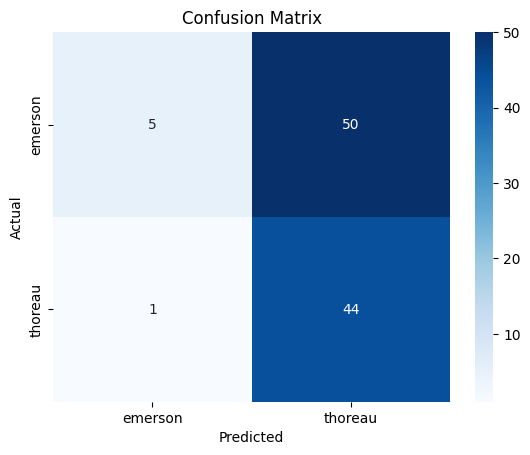

In [117]:
show_metrics(y_actual_subset, y_pred_subset, "Zero shot learning")

In [86]:
# TODO: we are overrunning our max tokens by quite a lot for this model and number of samples. Let's reduce sample size.
from tqdm import tqdm

MAX_SAMPLES = 100 # TODO: remove and/or increase

texts = training_df["text"].tolist()
y_actual = training_df["label"].tolist()

x_subset = texts[:MAX_SAMPLES]
y_actual_subset = y_actual[:MAX_SAMPLES]


# use tqdm to show progress
y_pred_subset = [few_shot_classify_text(text, "Emerson", "Thoreau", few_shot_hypothesis)[0] for text in tqdm(x_subset)]



  0%|          | 0/100 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.

  1%|          | 1/100 [00:02<03:59,  2.42s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.

  2%|▏         | 2/100 [00:04<03:42,  2.27s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.

  3%|▎         | 3/100 [00:06<03:11,  1.97s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation str

# Few shot learning

              precision    recall  f1-score   support

     Thoreau       0.00      0.00      0.00       0.0
     emerson       0.00      0.00      0.00      55.0
     thoreau       0.00      0.00      0.00      45.0

    accuracy                           0.00     100.0
   macro avg       0.00      0.00      0.00     100.0
weighted avg       0.00      0.00      0.00     100.0

Test accuracy: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

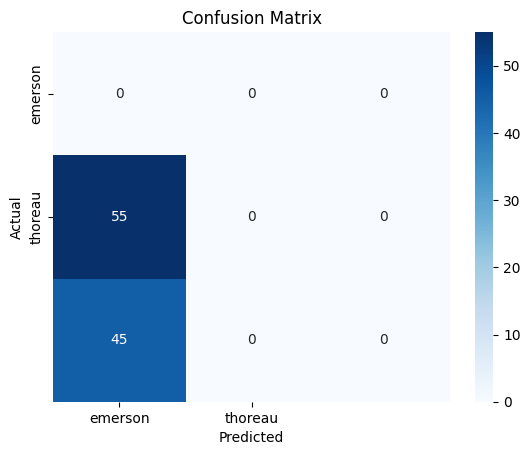

In [87]:
show_metrics(y_actual_subset, y_pred_subset, "Few shot learning")